# 7.0 - Expected Pitch Effectiveness
Modeling expected pitch effectiveness based on situation (count, handedness, etc) to understand pitch usage and performance.

## Libraries

In [1]:
import logging
import sys
import warnings

import os

import pandas as pd
import numpy as np

from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    explained_variance_score,
    mean_absolute_error
)

from yellowbrick.classifier import (
    ClassificationReport,
    ROCAUC,
    ClassPredictionError,
    DiscriminationThreshold
)
from yellowbrick.regressor import (
    PredictionError,
    ResidualsPlot
)

## Setup

In [2]:
# Supress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# BQ Logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [4]:
# BigQuery
PROJECT_ID = 'ad-fantasy-baseball'
CREDENTIALS_PATH = os.path.join(os.pardir, './credentials/mlb-db-analysis-user.json')

In [5]:
# Pandas
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

In [6]:
# Seaborn
sns.set(rc={'figure.figsize': (16, 9)})

## Data

In [7]:
params = {
    'min_year': 2016
}

In [1]:
SQL = \
"""
SELECT
  t_event.*,
  t_player.mlb_name AS pitcher_name
FROM
  (
    SELECT
      event_id,
      MAX(game_year) AS game_year,
      MAX(pitcher) AS pitcher_id,
      MAX(p_throws) AS pitcher_hand,
      MAX(stand) AS batter_hand,
      MAX(balls) AS balls,
      MAX(strikes) AS strikes,
      CONCAT(CAST(MAX(balls) AS STRING), '-', CAST(MAX(strikes) AS STRING)) AS count,
      MAX(pitch_type) AS pitch_type,
      MAX(description) AS description,
      MAX(events) AS events,
      MAX(estimated_woba_using_speedangle) AS estimated_woba_using_speedangle,
      MAX(woba_value) AS woba_value,
      MAX(woba_denom) AS woba_denom
    FROM
      `ad-fantasy-baseball.core.statcast_extended`
    WHERE
      game_year >= {min_year}
        AND description NOT IN (
          'foul_bunt',
          'hit_by_pitch',
          'intent_ball',
          'missed_bunt',
          'pitchout',
          'bunt_foul_tip',
          'swinging_pitchout',
          'foul_pitchout',
          'pitchout_hit_into_play',
          'pitchout_hit_into_play_score'
        )
    GROUP BY 1
  ) t_event
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `ad-fantasy-baseball.core.players`
  ) t_player
    ON (t_event.pitcher_id = t_player.mlb_id)
"""

In [2]:
sql_base = SQL.format(**params)
df_base = read_gbq(
    query=sql_base,
    dialect='standard',
    project_id=PROJECT_ID,
    private_key=CREDENTIALS_PATH,
    configuration={'query': {'useQueryCache': False}}
)

df_copy = df_base.copy()

NameError: name 'params' is not defined

In [10]:
df_base.head()

,event_id,game_year,pitcher_id,pitcher_hand,batter_hand,balls,strikes,count,pitch_type,description,events,estimated_woba_using_speedangle,woba_value,woba_denom,pitcher_name
0,564842.64.3,2019,543022,R,R,0,2,0-2,FC,ball,None,None,None,None,Tyler Chatwood
1,564843.35.6,2019,506433,R,L,2,2,2-2,FF,ball,None,None,None,None,Yu Darvish
2,564843.62.3,2019,594986,L,R,0,2,0-2,SI,ball,None,None,None,None,Kyle Ryan
3,564843.43.2,2019,506433,R,L,1,0,1-0,FF,called_strike,None,None,None,None,Yu Darvish
4,564844.66.3,2019,518553,R,L,0,2,0-2,FF,ball,None,None,None,None,Steve Cishek


## Data prep

In [11]:
# Remove bad data
df_base = df_base[df_base['balls'] < 4]
df_base = df_base[df_base['strikes'] < 3]

In [12]:
# Data formatting
numeric_cols = [
    'balls',
    'strikes',
    'estimated_woba_using_speedangle',
    'woba_value',
    'woba_denom'
]

df_base[numeric_cols] = df_base[numeric_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [13]:
# Outcome filters
outcomes_strike = [
    'called_strike',
    'swinging_strike',
    'swinging_strike_blocked',
    'missed_bunt'
]
outcomes_swinging_strike = [
    'swinging_strike',
    'swinging_strike_blocked',
    'missed_bunt'
]
outcomes_ball = [
    'ball',
    'blocked_ball',
    'pitchout',
    'hit_by_pitch'
]
outcomes_contact = [
    'hit_into_play',
    'hit_into_play_no_out',
    'hit_into_play_score',
    'foul',
    'foul_tip',
    'foul_bunt'
]
outcomes_swing = [
    'swinging_strike',
    'swinging_strike_blocked',
    'hit_into_play',
    'hit_into_play_no_out',
    'hit_into_play_score',
    'foul',
    'foul_tip'
]

_pitcher_r = df_base['pitcher_hand'] == 'R'
_batter_r = df_base['batter_hand'] == 'R'
_strike = df_base['description'].isin(outcomes_strike)
_ball = df_base['description'].isin(outcomes_ball)
_contact = df_base['description'].isin(outcomes_contact)
_swing = df_base['description'].isin(outcomes_swing)
_woba_denom = df_base['woba_denom'] == 1

In [14]:
df_base['flag_strike'] = np.where(df_base['description'].isin(outcomes_strike), 1, 0)
df_base['flag_contact'] = np.where(df_base['description'].isin(outcomes_contact), 1, 0)
df_base['flag_swstr'] = np.where(df_base['description'].isin(outcomes_swinging_strike), 1, 0)
df_base['flag_cstr'] = np.where(df_base['description'] == 'called_strike', 1, 0)

df_base['flag_00'] = np.where(df_base['count'] == '0-0', 1, 0)
df_base['flag_01'] = np.where(df_base['count'] == '0-1', 1, 0)
df_base['flag_02'] = np.where(df_base['count'] == '0-2', 1, 0)
df_base['flag_10'] = np.where(df_base['count'] == '1-0', 1, 0)
df_base['flag_11'] = np.where(df_base['count'] == '1-1', 1, 0)
df_base['flag_12'] = np.where(df_base['count'] == '1-2', 1, 0)
df_base['flag_20'] = np.where(df_base['count'] == '2-0', 1, 0)
df_base['flag_21'] = np.where(df_base['count'] == '2-1', 1, 0)
df_base['flag_22'] = np.where(df_base['count'] == '2-2', 1, 0)
df_base['flag_30'] = np.where(df_base['count'] == '3-0', 1, 0)
df_base['flag_31'] = np.where(df_base['count'] == '3-1', 1, 0)
df_base['flag_32'] = np.where(df_base['count'] == '3-2', 1, 0)

df_base['flag_platoon'] = np.where(df_base['pitcher_hand'] == df_base['batter_hand'], 1, 0)

df_base['woba'] = df_base['woba_value'] / df_base['woba_denom']

In [15]:
df_base.head(10)

,event_id,game_year,pitcher_id,pitcher_hand,batter_hand,balls,strikes,count,pitch_type,description,events,estimated_woba_using_speedangle,woba_value,woba_denom,pitcher_name,flag_strike,flag_contact,flag_swstr,flag_cstr,flag_00,flag_01,flag_02,flag_10,flag_11,flag_12,flag_20,flag_21,flag_22,flag_30,flag_31,flag_32,flag_platoon,woba
0,564842.64.3,2019,543022,R,R,0,2,0-2,FC,ball,None,NaN,NaN,NaN,Tyler Chatwood,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,NaN
1,564843.35.6,2019,506433,R,L,2,2,2-2,FF,ball,None,NaN,NaN,NaN,Yu Darvish,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN
2,564843.62.3,2019,594986,L,R,0,2,0-2,SI,ball,None,NaN,NaN,NaN,Kyle Ryan,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN
3,564843.43.2,2019,506433,R,L,1,0,1-0,FF,called_strike,None,NaN,NaN,NaN,Yu Darvish,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN
4,564844.66.3,2019,518553,R,L,0,2,0-2,FF,ball,None,NaN,NaN,NaN,Steve Cishek,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN
5,564844.4.3,2019,500779,L,R,2,0,2-0,FF,ball,None,NaN,NaN,NaN,Jose Quintana,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN
6,564844.11.3,2019,500779,L,L,0,2,0-2,SI,foul,None,NaN,NaN,NaN,Jose Quintana,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,NaN
7,564844.95.3,2019,445213,R,R,0,2,0-2,SI,foul,None,NaN,NaN,NaN,Brandon Kintzler,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,NaN
8,564844.31.4,2019,500779,L,R,2,1,2-1,FF,ball,None,NaN,NaN,NaN,Jose Quintana,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NaN
9,564844.11.4,2019,500779,L,L,0,2,0-2,FF,foul,None,NaN,NaN,NaN,Jose Quintana,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,NaN


## Modeling

In [16]:
def train_and_evaluate_classifier(
        df,
        label,
        features,
        model,
        test_size=0.15,
        decision_threshold=0.5,
        discrimination_plot=False
    ):
    
    # Train model
    y = df[label]
    X = df[features]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred_proba = [ y[1] for y in model.predict_proba(X_test) ]
    y_pred = [ 1 if y > decision_threshold else 0 for y in y_pred_proba ]
    
    # Model description
    model_name = type(model).__name__
    
    if model_name in ['LogisticRegression']:
        print('MODEL COEFFICIENTS FOR {:s} MODEL'.format(model_name))
        
        intercept = model.intercept_[0]
        if intercept > 0:
            print("{:30}[{:5.3f}]".format('Intercept:', intercept))
        
        for feature, weight in list(zip(features, model.coef_[0])):
            print("{:30}[{:5.4f}]".format(feature + ":", weight))
        print('\n')
                
    # Model metrics
    prs = precision_score(y_test, y_pred)
    res = recall_score(y_test, y_pred)
    acs = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print('MODEL METRICS FOR {:s} MODEL'.format(model_name))
    print('Precision Score: {:5.4f}'.format(prs))
    print('Recall Score: {:5.4f}'.format(res))
    print('Accuracy Score: {:5.4f}'.format(acs))
    print('F1 Score: {:5.4f}'.format(f1))
    
    print('\nCONFUSION MATRIC FOR {:s} MODEL'.format(model_name))
    print(confusion_matrix(y_test, y_pred))
    
    # Classification Report
    class_report = ClassificationReport(model)
    class_report.fit(X_train, y_train)
    class_report.score(X_test, y_test)
    class_report.poof()

    # ROC AUC
    rocauc = ROCAUC(model)
    rocauc.fit(X_train, y_train)
    rocauc.score(X_test, y_test)
    rocauc.poof()
    
    # Class Prediction Error Report
    cpe_report = ClassPredictionError(model)
    cpe_report.fit(X_train, y_train)
    cpe_report.score(X_test, y_test)
    cpe_report.poof()
    
    # Discrimination Threshold Curve
    if discrimination_plot:
        dt_curve = DiscriminationThreshold(model)
        dt_curve.fit(X_train, y_train)
        dt_curve.poof()

In [17]:
def train_and_evaluate_regressor(
        df,
        label,
        features,
        model,
        test_size=0.15
    ):
    
    # Train model
    y = df[label]
    X = df[features]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    
    # Model description
    model_name = type(model).__name__
    
    if model_name in ['LinearRegression']:
        print('MODEL COEFFICIENTS FOR {:s} MODEL'.format(model_name))
        
        intercept = model.intercept_
        if intercept != 0:
            print("{:30}[{:5.3f}]".format('Intercept:', intercept))
        
        for feature, weight in list(zip(features, model.coef_)):
            print("{:30}[{:5.4f}]".format(feature + ":", weight))
        print('\n')
                
    # Model metrics
    evs = explained_variance_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
        
    print('MODEL METRICS FOR {:s} MODEL'.format(model_name))
    print('Explained Variance Score: {:5.4f}'.format(evs))
    print('Mean Absolute Error: {:5.4f}'.format(mae))
    
    # Classification Report
    prediction_error = PredictionError(model)
    prediction_error.fit(X_train, y_train)
    prediction_error.score(X_test, y_test)
    prediction_error.poof()

    # ROC AUC
    residuals_plot = ResidualsPlot(model)
    residuals_plot.fit(X_train, y_train)
    residuals_plot.score(X_test, y_test)
    residuals_plot.poof()

### Predicting swinging strike percentage

MODEL COEFFICIENTS FOR LogisticRegression MODEL
flag_00:                      [-0.5494]
flag_01:                      [0.0812]
flag_02:                      [0.2343]
flag_10:                      [-0.1696]
flag_11:                      [0.1263]
flag_12:                      [0.2910]
flag_20:                      [-0.3258]
flag_21:                      [0.0933]
flag_22:                      [0.2471]
flag_30:                      [-2.0493]
flag_31:                      [-0.2157]
flag_32:                      [0.0952]
flag_platoon:                 [0.1310]


MODEL METRICS FOR LogisticRegression MODEL
Precision Score: 0.1265
Recall Score: 0.7422
Accuracy Score: 0.4306
F1 Score: 0.2161

CONFUSION MATRIC FOR LogisticRegression MODEL
[[135807 209150]
 [ 10519  30281]]


/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


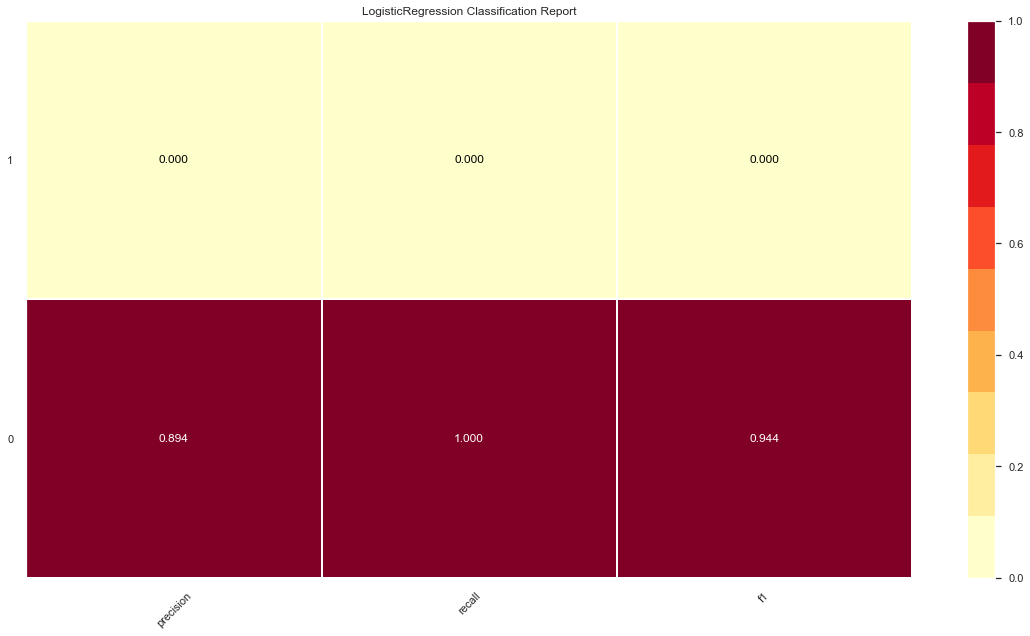

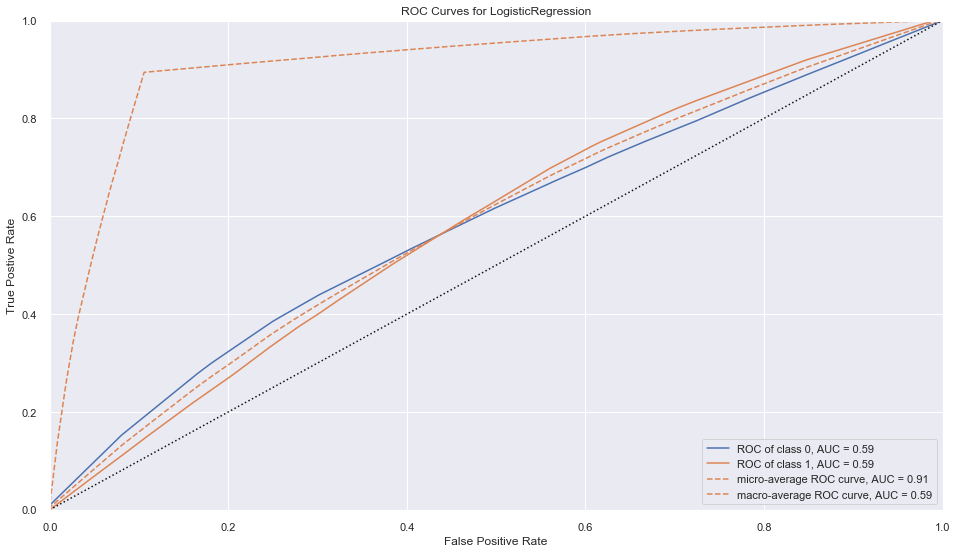

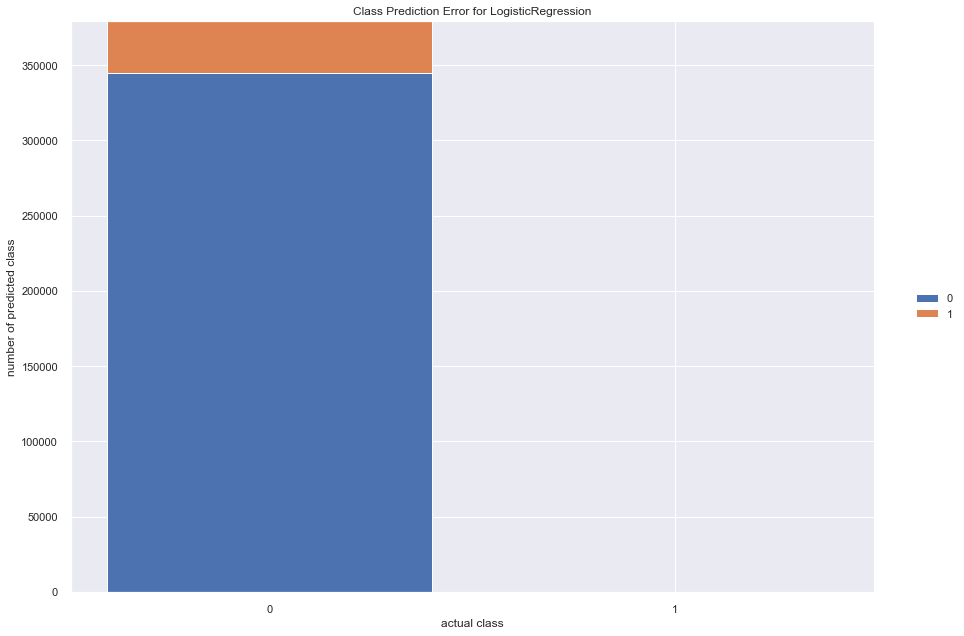

In [18]:
df_swstr = df_base.copy()

swstr_label = 'flag_swstr'
swstr_classes = ['contact', 'swinging_strike']
swstr_features = [
    'flag_00',
    'flag_01',
    'flag_02',
    'flag_10',
    'flag_11',
    'flag_12',
    'flag_20',
    'flag_21',
    'flag_22',
    'flag_30',
    'flag_31',
    'flag_32',
    'flag_platoon'
]
swstr_model = LogisticRegression(
    fit_intercept=True
)

train_and_evaluate_classifier(
    df=df_swstr,
    label=swstr_label,
    features=swstr_features,
    model=swstr_model,
    decision_threshold=0.1
)

In [19]:
# # Predict specific situations
# for hand in range(0, 2):
#     for feature in range(0, 12):
#         weights = np.zeros(12)
#         weights[feature] = 1
#         weights = np.append(weights, hand)

#         print(weights)
#         print(swstr_model.predict_proba(X=[weights]))

### Predicting whiff-per-swing percentage

MODEL COEFFICIENTS FOR LogisticRegression MODEL
flag_00:                      [0.0554]
flag_01:                      [0.1382]
flag_02:                      [0.2080]
flag_10:                      [-0.0107]
flag_11:                      [0.0251]
flag_12:                      [0.1084]
flag_20:                      [-0.2306]
flag_21:                      [-0.1277]
flag_22:                      [-0.0927]
flag_30:                      [-0.5165]
flag_31:                      [-0.4391]
flag_32:                      [-0.3912]
flag_platoon:                 [0.1149]


MODEL METRICS FOR LogisticRegression MODEL
Precision Score: 0.2507
Recall Score: 0.5435
Accuracy Score: 0.5291
F1 Score: 0.3432

CONFUSION MATRIC FOR LogisticRegression MODEL
[[73296 66331]
 [18641 22197]]


/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


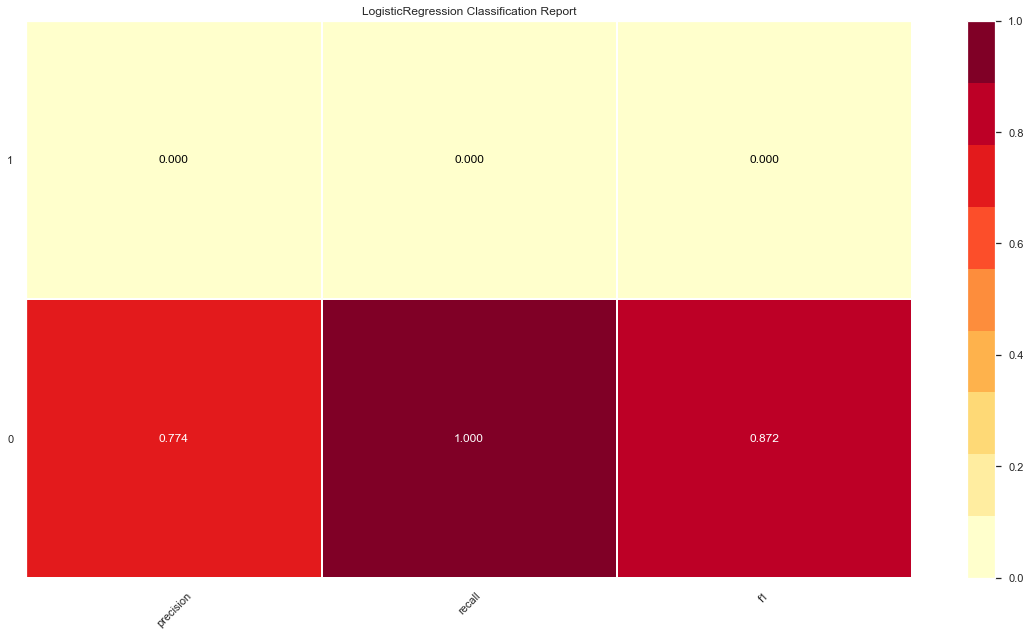

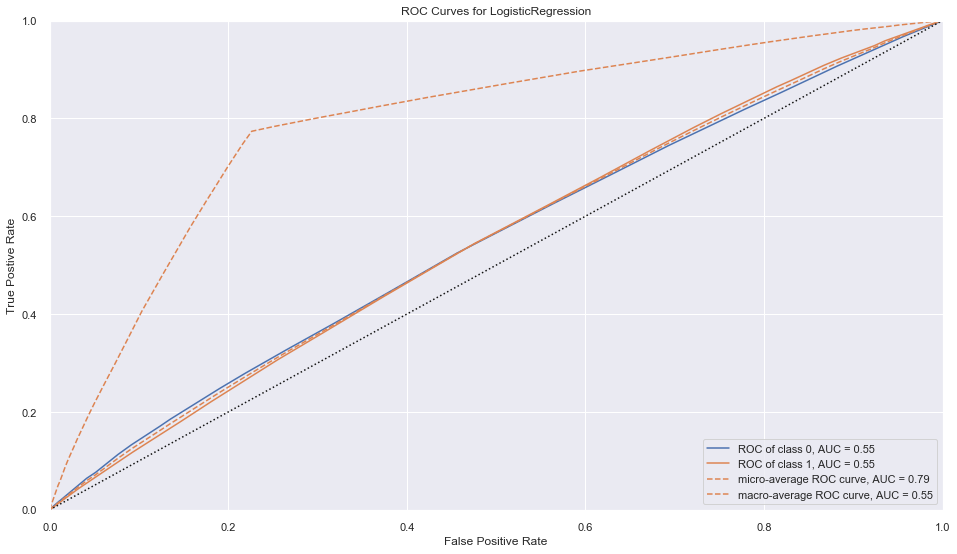

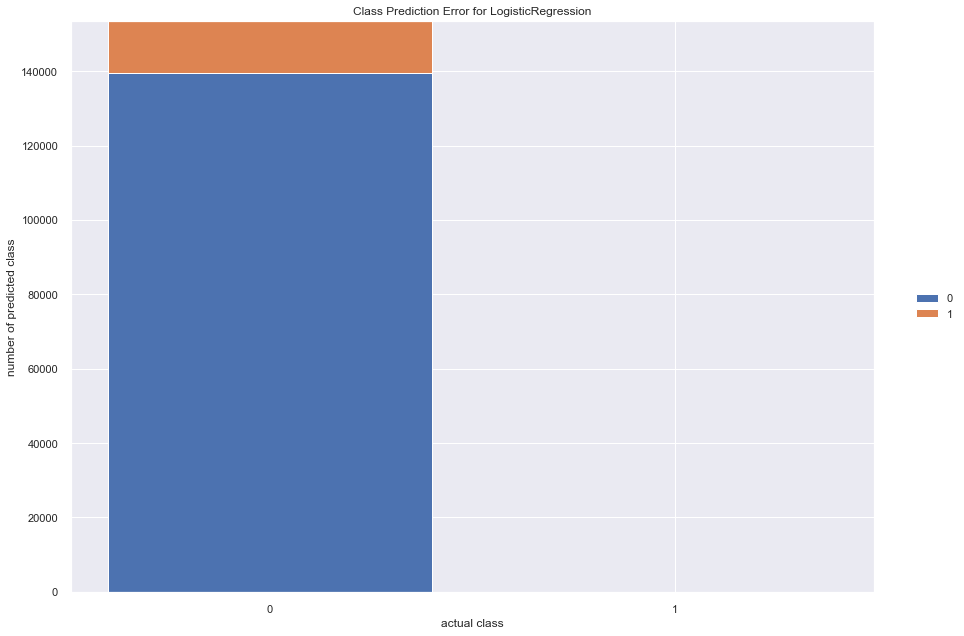

In [20]:
df_whiff = df_base[_swing].copy()

whiff_label = 'flag_swstr'
whiff_classes = ['contact', 'swinging_strike']
whiff_features = [
    'flag_00',
    'flag_01',
    'flag_02',
    'flag_10',
    'flag_11',
    'flag_12',
    'flag_20',
    'flag_21',
    'flag_22',
    'flag_30',
    'flag_31',
    'flag_32',
    'flag_platoon'
]
whiff_model = LogisticRegression(
    fit_intercept=True
)

train_and_evaluate_classifier(
    df=df_whiff,
    label=whiff_label,
    features=whiff_features,
    model=whiff_model,
    decision_threshold=0.23
)

In [21]:
# # Predict specific situations
# for hand in range(0, 2):
#     for feature in range(0, 12):
#         weights = np.zeros(12)
#         weights[feature] = 1
#         weights = np.append(weights, hand)

#         print(weights)
#         print(whiff_model.predict_proba(X=[weights]))

### Predicting wOBA

/Users/ad/Documents/projects/mlb-db-analysis/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


MODEL COEFFICIENTS FOR LinearRegression MODEL
flag_00:                      [0.4042]
flag_01:                      [0.3686]
flag_02:                      [0.1723]
flag_10:                      [0.4135]
flag_11:                      [0.3903]
flag_12:                      [0.1854]
flag_20:                      [0.4389]
flag_21:                      [0.4107]
flag_22:                      [0.2107]
flag_30:                      [0.6804]
flag_31:                      [0.5822]
flag_32:                      [0.3915]
flag_platoon:                 [-0.0079]


MODEL METRICS FOR LinearRegression MODEL
Explained Variance Score: 0.0568
Mean Absolute Error: 0.4092


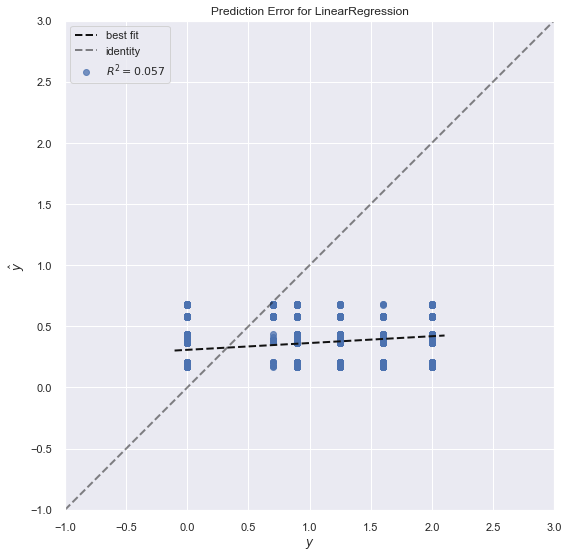

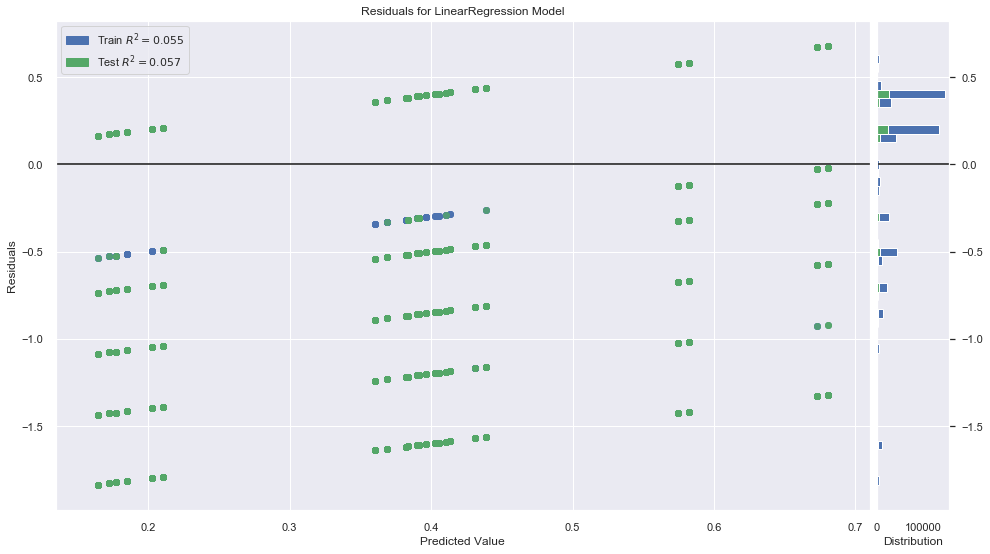

In [22]:
df_woba = df_base[_woba_denom].copy()

woba_label = 'woba'
woba_features = [
    'flag_00',
    'flag_01',
    'flag_02',
    'flag_10',
    'flag_11',
    'flag_12',
    'flag_20',
    'flag_21',
    'flag_22',
    'flag_30',
    'flag_31',
    'flag_32',
    'flag_platoon'
]
woba_model = LinearRegression(
    fit_intercept=False
)

train_and_evaluate_regressor(
    df=df_woba,
    label=woba_label,
    features=woba_features,
    model=woba_model
)

In [23]:
# # Predict specific situations
# for hand in range(0, 2):
#     for feature in range(0, 12):
#         weights = np.zeros(12)
#         weights[feature] = 1
#         weights = np.append(weights, hand)

#         print(weights)
#         print(woba_model.predict(X=[weights]))

## Analysis

### Swinging strike rate

In [24]:
# Apply model(s) to pitch-level data
df_pred_swstr = df_swstr[swstr_features]

df_swstr['pred_swstr'] = [ pred[1] for pred in swstr_model.predict_proba(X=df_pred_swstr) ]

#### Since 2016

In [25]:
df_summary_swstr = df_swstr.groupby(['pitcher_id', 'pitcher_name', 'pitch_type']).agg({
    'event_id': 'count',
    'flag_swstr': 'mean',
    'pred_swstr': 'mean'
}).rename(columns={
    'event_id': 'pitches',
    'flag_swstr': 'swstr'
})

df_summary_swstr['delta_swstr'] = df_summary_swstr['swstr'] - df_summary_swstr['pred_swstr']

In [26]:
df_summary_swstr[df_summary_swstr['pitches'] > 100]\
    .sort_values(by=['pred_swstr'], ascending=False)\
    .head(10)

,,,pitches,swstr,pred_swstr,delta_swstr
pitcher_id,pitcher_name,pitch_type,,,,
448306,James Shields,EP,205,0.190244,0.137850,0.052394
476454,Dellin Betances,SL,394,0.203046,0.137681,0.065365
434671,Anibal Sanchez,CH,248,0.209677,0.132005,0.077672
518553,Steve Cishek,FF,284,0.176056,0.131878,0.044178
657610,Trevor Hildenberger,FF,149,0.080537,0.131756,-0.051219
467100,Ivan Nova,FC,147,0.197279,0.131559,0.065720
607192,Tyler Glasnow,SL,172,0.261628,0.131496,0.130132
545333,Trevor Bauer,SL,679,0.206186,0.131279,0.074907
445276,Kenley Jansen,SL,306,0.228758,0.129763,0.098995


In [27]:
# Summary filters
_cutoff_swstr = df_summary_swstr['pitches'] > 500

df_summary_swstr_f = df_summary_swstr[_cutoff_swstr]

Text(0.5,1,'SwStr % over expectation as a function of predicted SwStr %, since 2016')

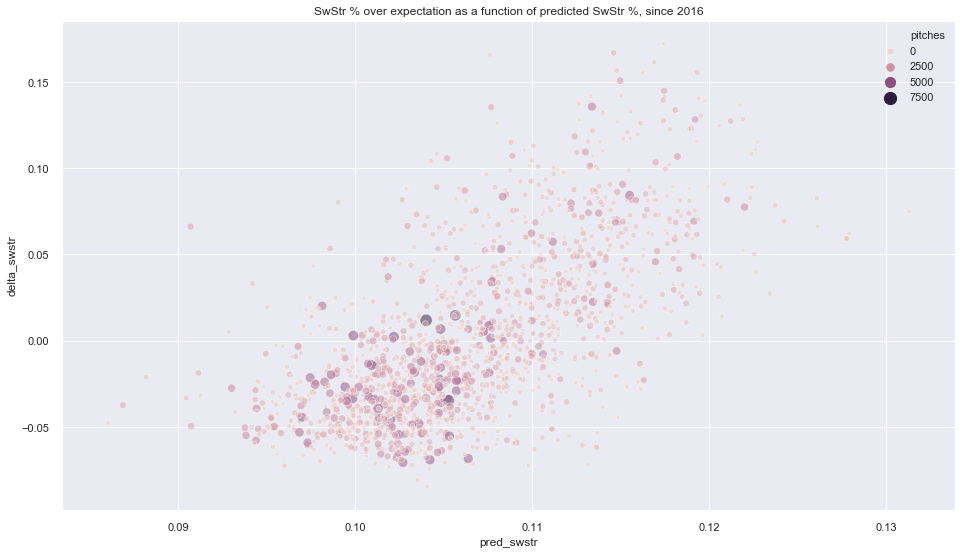

In [28]:
sns.scatterplot(
    x=df_summary_swstr_f['pred_swstr'],
    y=df_summary_swstr_f['delta_swstr'],
    hue=df_summary_swstr_f['pitches'],
    size=df_summary_swstr_f['pitches'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('SwStr % over expectation as a function of predicted SwStr %, since 2016')

Text(0.5,1,'SwStr % over expectation as a function of pitch count, since 2016')

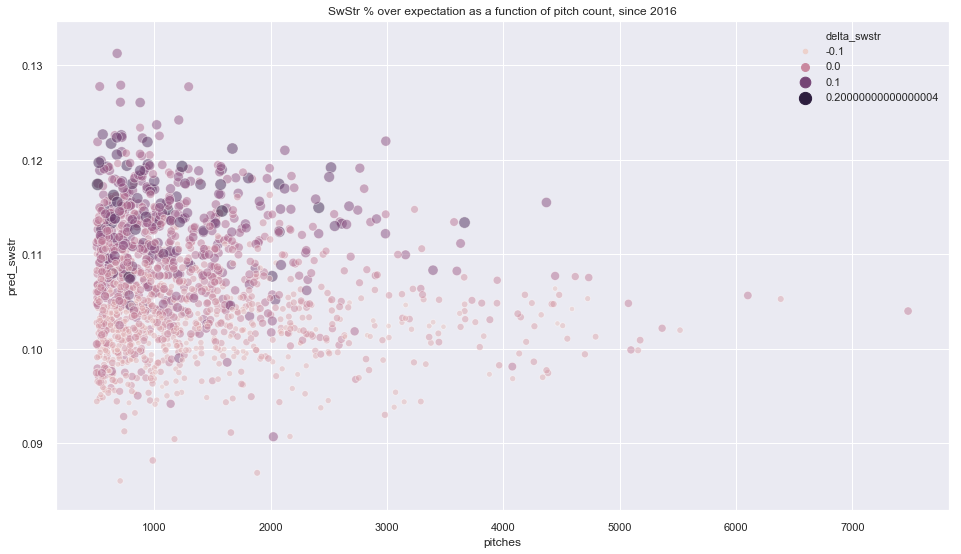

In [29]:
sns.scatterplot(
    x=df_summary_swstr_f['pitches'],
    y=df_summary_swstr_f['pred_swstr'],
    hue=df_summary_swstr_f['delta_swstr'],
    size=df_summary_swstr_f['delta_swstr'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('SwStr % over expectation as a function of pitch count, since 2016')

#### Pitches in 2019

In [30]:
df_swstr_2019 = df_swstr[df_swstr['game_year'] == 2019].groupby(['pitcher_id', 'pitcher_name', 'pitch_type']).agg({
    'event_id': 'count',
    'flag_swstr': 'mean',
    'pred_swstr': 'mean'
}).rename(columns={
    'event_id': 'pitches',
    'flag_swstr': 'swstr'
})

df_swstr_2019['delta_swstr'] = df_swstr_2019['swstr'] - df_swstr_2019['pred_swstr']

In [31]:
df_swstr_2019[df_swstr_2019['pitches'] > 50].sort_values(by=['swstr'], ascending=False).head(10)

,,,pitches,swstr,pred_swstr,delta_swstr
pitcher_id,pitcher_name,pitch_type,,,,
669203,Corbin Burnes,SL,214,0.369159,0.119862,0.249297
663432,Tanner Rainey,SL,87,0.333333,0.115425,0.217908
628452,Raisel Iglesias,CH,113,0.318584,0.118658,0.199926
580792,Nick Goody,SL,63,0.317460,0.114528,0.202932
622694,Elieser Hernandez,SL,89,0.303371,0.111327,0.192044
596112,Robert Stephenson,SL,246,0.300813,0.111593,0.189220
467008,Pedro Strop,SL,130,0.300000,0.115305,0.184695
592454,Tommy Kahnle,CH,215,0.293023,0.112347,0.180677
571760,Andrew Heaney,CU,134,0.291045,0.120026,0.171019


In [32]:
# Summary filters
_cutoff_year_swstr = df_swstr_2019['pitches'] > 50

df_swstr_2019_f = df_swstr_2019[_cutoff_year_swstr]

Text(0.5,1,'SwStr % over expectation as a function of predicted SwStr %, 2019')

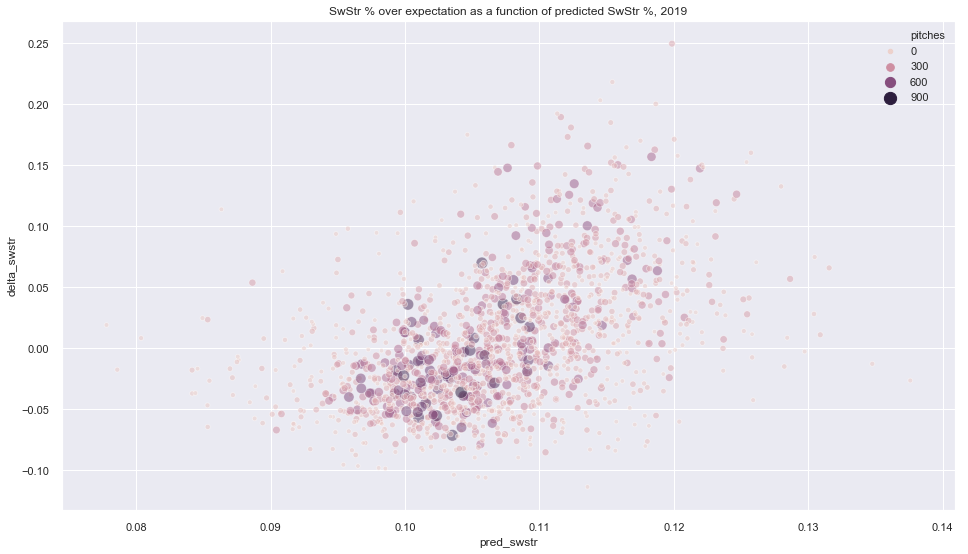

In [33]:
sns.scatterplot(
    x=df_swstr_2019_f['pred_swstr'],
    y=df_swstr_2019_f['delta_swstr'],
    hue=df_swstr_2019_f['pitches'],
    size=df_swstr_2019_f['pitches'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('SwStr % over expectation as a function of predicted SwStr %, 2019')

Text(0.5,1,'SwStr % over expectation as a function of pitch count, 2019')

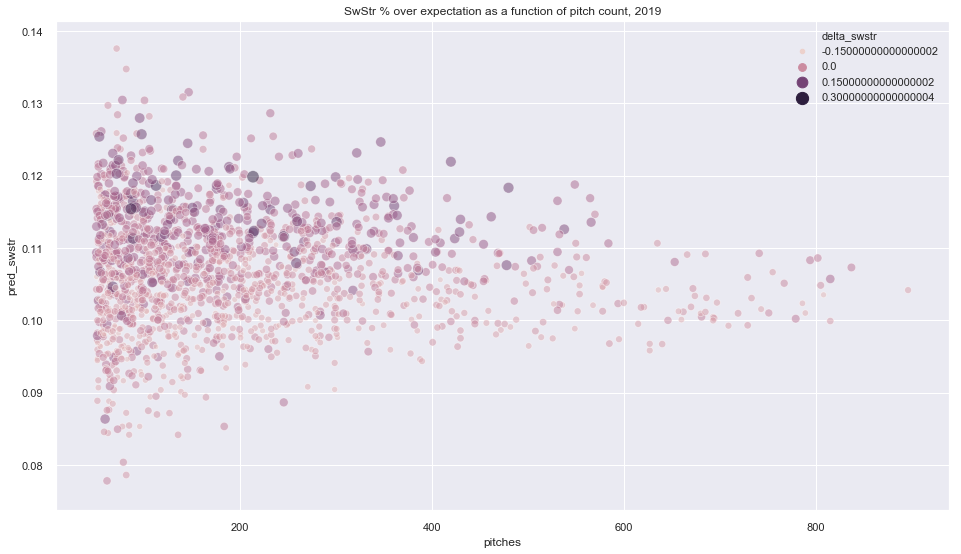

In [34]:
sns.scatterplot(
    x=df_swstr_2019_f['pitches'],
    y=df_swstr_2019_f['pred_swstr'],
    hue=df_swstr_2019_f['delta_swstr'],
    size=df_swstr_2019_f['delta_swstr'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('SwStr % over expectation as a function of pitch count, 2019')

#### Export data

In [35]:
df_swstr_2019.to_csv('~/Desktop/expected_swstr_2019.csv')
df_summary_swstr.to_csv('~/Desktop/expected_swstr_all_time.csv')

### Whiff-per-swing percentage

In [36]:
# Apply model(s) to pitch-level data
df_pred_whiff = df_whiff[whiff_features]

df_whiff['pred_whiff'] = [ pred[1] for pred in whiff_model.predict_proba(X=df_pred_whiff)]

#### Since 2016

In [37]:
df_summary_whiff = df_whiff.groupby(['pitcher_id', 'pitcher_name', 'pitch_type']).agg({
    'event_id': 'count',
    'flag_swstr': 'mean',
    'pred_whiff': 'mean'
}).rename(columns={
    'event_id': 'pitches',
    'flag_swstr': 'whiff'
})

df_summary_whiff['delta_whiff'] = df_summary_whiff['whiff'] - df_summary_whiff['pred_whiff']

In [38]:
df_summary_whiff[df_summary_whiff['pitches'] > 100]\
    .sort_values(by=['pred_whiff'], ascending=False)\
    .head(10)

,,,pitches,whiff,pred_whiff,delta_whiff
pitcher_id,pitcher_name,pitch_type,,,,
448306,James Shields,EP,113,0.345133,0.251959,0.093174
446899,Brad Ziegler,CU,255,0.388235,0.250089,0.138146
516969,Kelvin Herrera,SL,211,0.436019,0.249254,0.186765
643256,Adam Cimber,SL,170,0.258824,0.248756,0.010067
453265,Tony Watson,SL,249,0.349398,0.248359,0.101039
518560,Paul Clemens,CU,146,0.232877,0.248273,-0.015396
622554,Seranthony Dominguez,SL,200,0.460000,0.248056,0.211944
519096,Dan Otero,SL,127,0.251969,0.247607,0.004362
453344,Brandon Morrow,SL,157,0.343949,0.247415,0.096534


In [39]:
# Summary filters
_cutoff_whiff = df_summary_whiff['pitches'] > 250

df_summary_whiff_f = df_summary_whiff[_cutoff_whiff]

Text(0.5,1,'Whiff % over expectation as a function of predicted Whiff %, since 2016')

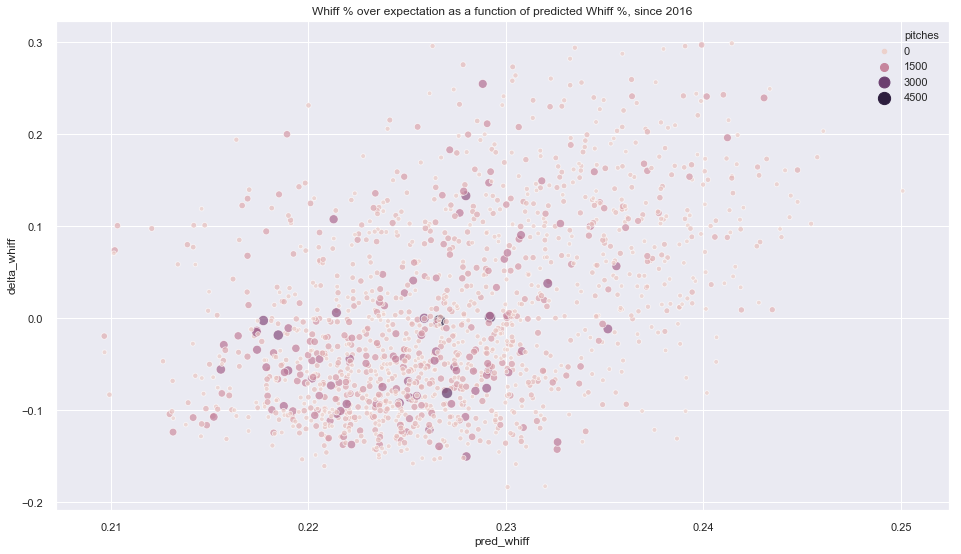

In [40]:
sns.scatterplot(
    x=df_summary_whiff_f['pred_whiff'],
    y=df_summary_whiff_f['delta_whiff'],
    hue=df_summary_whiff_f['pitches'],
    size=df_summary_whiff_f['pitches'],
    sizes=(20, 150),
    alpha=0.7
)

plt.title('Whiff % over expectation as a function of predicted Whiff %, since 2016')

Text(0.5,1,'Whiff % over expectation as a function of pitch count, since 2016')

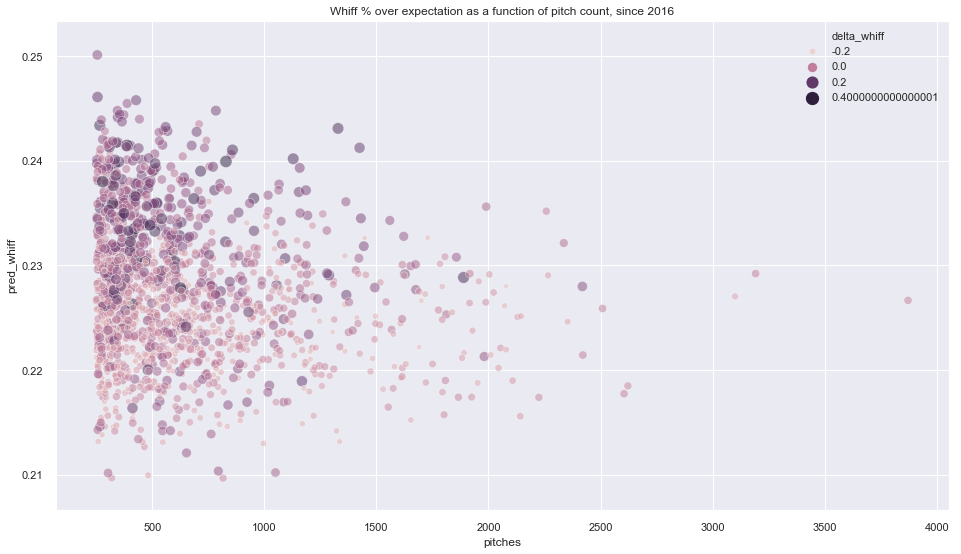

In [41]:
sns.scatterplot(
    x=df_summary_whiff_f['pitches'],
    y=df_summary_whiff_f['pred_whiff'],
    hue=df_summary_whiff_f['delta_whiff'],
    size=df_summary_whiff_f['delta_whiff'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('Whiff % over expectation as a function of pitch count, since 2016')

#### Pitches in 2019

In [42]:
df_whiff_2019 = df_whiff[df_whiff['game_year'] == 2019].groupby(['pitcher_id', 'pitcher_name', 'pitch_type']).agg({
    'event_id': 'count',
    'flag_swstr': 'mean',
    'pred_whiff': 'mean'
}).rename(columns={
    'event_id': 'pitches',
    'flag_swstr': 'whiff'
})

df_whiff_2019['delta_whiff'] = df_whiff_2019['whiff'] - df_whiff_2019['pred_whiff']

In [43]:
df_whiff_2019[df_whiff_2019['pitches'] > 50].sort_values(by=['whiff'], ascending=False).head(10)

,,,pitches,whiff,pred_whiff,delta_whiff
pitcher_id,pitcher_name,pitch_type,,,,
669203,Corbin Burnes,SL,129,0.612403,0.242963,0.369440
571704,Ken Giles,SL,103,0.592233,0.239834,0.352399
571656,Buck Farmer,SL,60,0.583333,0.248576,0.334758
663855,Jordan Hicks,SL,64,0.562500,0.233419,0.329081
669456,Shane Bieber,KC,128,0.554688,0.232766,0.321921
592773,Ryne Stanek,FS,65,0.553846,0.240685,0.313161
623433,Nick Anderson,CU,114,0.552632,0.239610,0.313022
605483,Blake Snell,CU,176,0.551136,0.223937,0.327199
571760,Andrew Heaney,CU,71,0.549296,0.242538,0.306758


In [44]:
# Summary filters
_cutoff_year_whiff = df_whiff_2019['pitches'] > 50

df_whiff_2019_f = df_whiff_2019[_cutoff_year_whiff]

Text(0.5,1,'Whiff % over expectation as a function of predicted Whiff %, 2019')

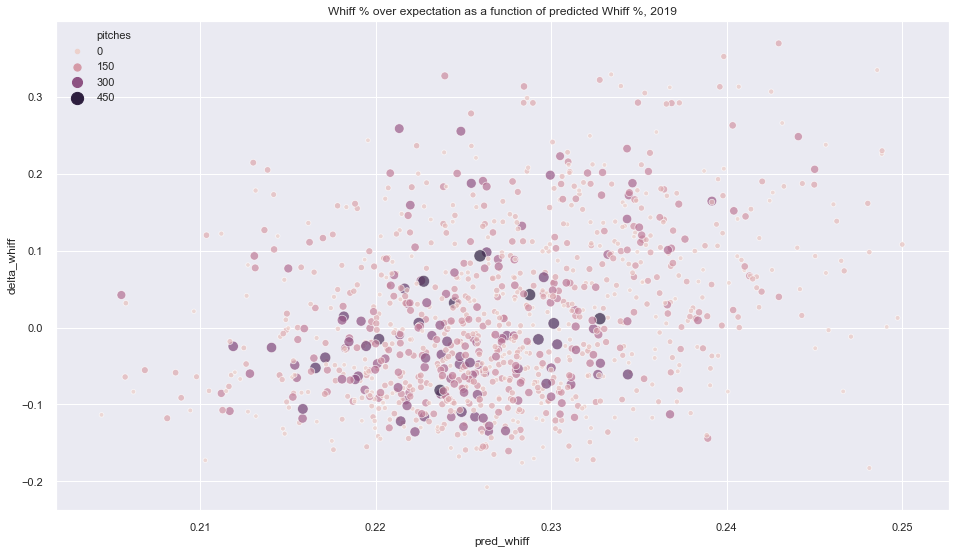

In [45]:
sns.scatterplot(
    x=df_whiff_2019_f['pred_whiff'],
    y=df_whiff_2019_f['delta_whiff'],
    hue=df_whiff_2019_f['pitches'],
    size=df_whiff_2019_f['pitches'],
    sizes=(20, 150),
    alpha=0.7
)

plt.title('Whiff % over expectation as a function of predicted Whiff %, 2019')

Text(0.5,1,'Whiff % over expectation as a function of pitch count, 2019')

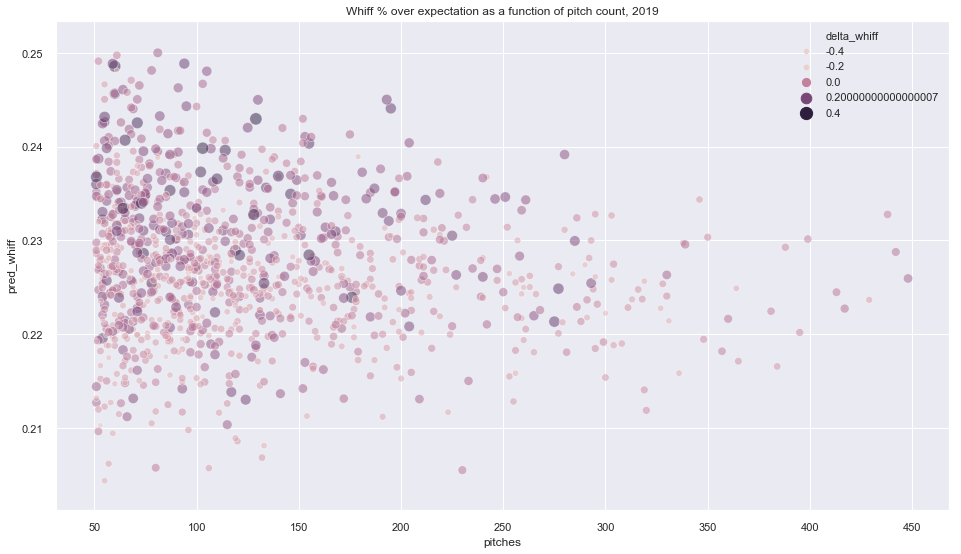

In [46]:
sns.scatterplot(
    x=df_whiff_2019_f['pitches'],
    y=df_whiff_2019_f['pred_whiff'],
    hue=df_whiff_2019_f['delta_whiff'],
    size=df_whiff_2019_f['delta_whiff'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('Whiff % over expectation as a function of pitch count, 2019')

#### Export data

In [47]:
df_whiff_2019.to_csv('~/Desktop/expected_whiff_2019.csv')
df_summary_whiff.to_csv('~/Desktop/expected_whiff_all_time.csv')

### wOBA

In [48]:
# Apply model(s) to pitch-level data
df_pred_woba = df_woba[woba_features]

df_woba['pred_woba'] = woba_model.predict(X=df_pred_woba)

#### Since 2016

In [49]:
df_summary_woba = df_woba.groupby(['pitcher_id', 'pitcher_name', 'pitch_type']).agg({
    'event_id': 'count',
    'woba': 'mean',
    'pred_woba': 'mean'
}).rename(columns={
    'event_id': 'events'
})

df_summary_woba['delta_woba'] = df_summary_woba['woba'] - df_summary_woba['pred_woba']

In [50]:
df_summary_woba[df_summary_woba['events'] > 100]\
    .sort_values(by=['woba'], ascending=True)\
    .head(10)

,,,events,woba,pred_woba,delta_woba
pitcher_id,pitcher_name,pitch_type,,,,
553878,Felipe Vazquez,SL,141,0.079078,0.203804,-0.124726
476454,Dellin Betances,SL,197,0.086802,0.200624,-0.113822
608566,German Marquez,KC,117,0.135043,0.224209,-0.089166
446372,Corey Kluber,CU,754,0.149337,0.241824,-0.092487
621237,Jose Alvarado,CU,129,0.150775,0.242189,-0.091414
650895,Diego Castillo,FC,120,0.151667,0.284439,-0.132773
664285,Framber Valdez,CU,101,0.153465,0.246439,-0.092974
434671,Anibal Sanchez,CH,110,0.155000,0.252373,-0.097373
545333,Trevor Bauer,CU,163,0.158589,0.242242,-0.083653


In [51]:
# Summary filters
_cutoff_woba = df_summary_woba['events'] > 250

df_summary_woba_f = df_summary_woba[_cutoff_woba]

Text(0.5,1,'wOBA over expectation as a function of predicted wOBA, since 2016')

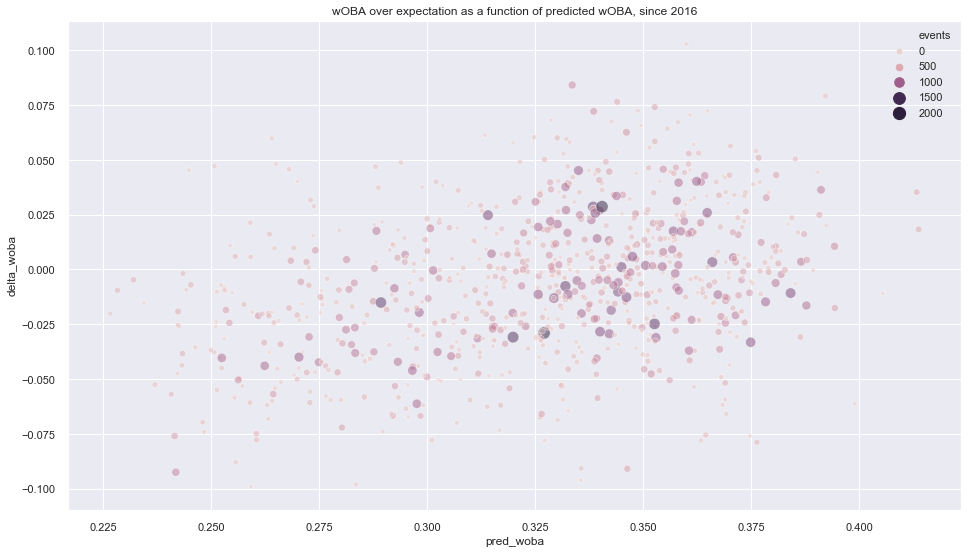

In [52]:
sns.scatterplot(
    x=df_summary_woba_f['pred_woba'],
    y=df_summary_woba_f['delta_woba'],
    hue=df_summary_woba_f['events'],
    size=df_summary_woba_f['events'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('wOBA over expectation as a function of predicted wOBA, since 2016')

Text(0.5,1,'wOBA over expectation as a function of events, since 2016')

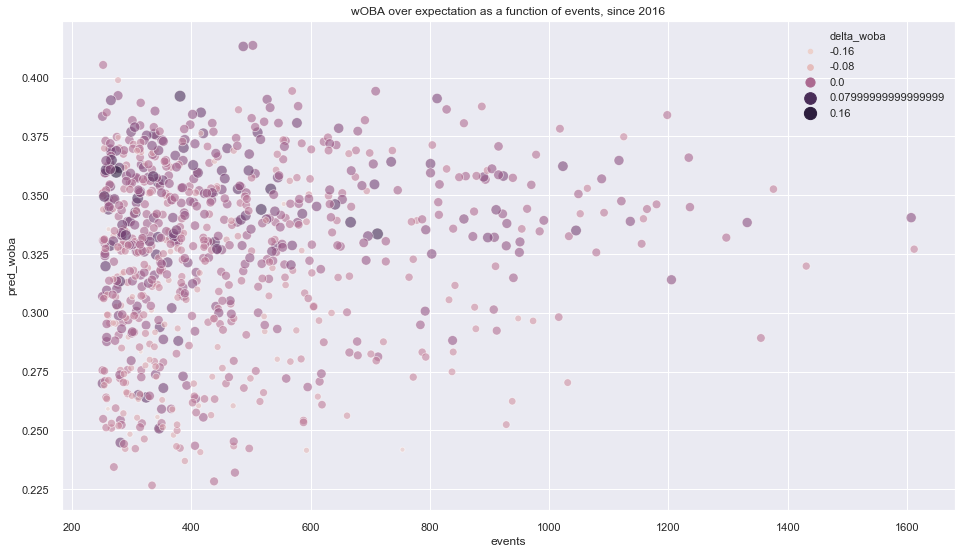

In [53]:
sns.scatterplot(
    x=df_summary_woba_f['events'],
    y=df_summary_woba_f['pred_woba'],
    hue=df_summary_woba_f['delta_woba'],
    size=df_summary_woba_f['delta_woba'],
    sizes=(20, 150),
    alpha=0.6
)

plt.title('wOBA over expectation as a function of events, since 2016')

#### Pitches in 2019

In [54]:
df_woba_2019 = df_woba[df_woba['game_year'] == 2019].groupby(['pitcher_id', 'pitcher_name', 'pitch_type']).agg({
    'event_id': 'count',
    'woba': 'mean',
    'pred_woba': 'mean'
}).rename(columns={
    'event_id': 'events'
})

df_woba_2019['delta_woba'] = df_woba_2019['woba'] - df_woba_2019['pred_woba']

In [55]:
df_woba_2019[df_woba_2019['events'] > 50].sort_values(by=['pred_woba'], ascending=True).head(10)

,,,events,woba,pred_woba,delta_woba
pitcher_id,pitcher_name,pitch_type,,,,
607192,Tyler Glasnow,CU,67,0.206716,0.220572,-0.013855
630023,Yonny Chirinos,FS,71,0.121831,0.221403,-0.099572
545333,Trevor Bauer,SL,76,0.267105,0.223356,0.043750
608566,German Marquez,KC,117,0.135043,0.224209,-0.089166
571927,Steven Matz,CU,65,0.357692,0.226654,0.131039
669203,Corbin Burnes,SL,60,0.218333,0.236714,-0.018381
450203,Charlie Morton,CU,145,0.130000,0.237650,-0.107650
571704,Ken Giles,SL,52,0.144231,0.239398,-0.095167
434378,Justin Verlander,CU,64,0.182031,0.240577,-0.058546


In [56]:
# Summary filters
_cutoff_year_woba = df_woba_2019['events'] > 50

df_woba_2019_f = df_woba_2019[_cutoff_year_woba]

Text(0.5,1,'wOBA over expectation as a function of predicted wOBA, 2019')

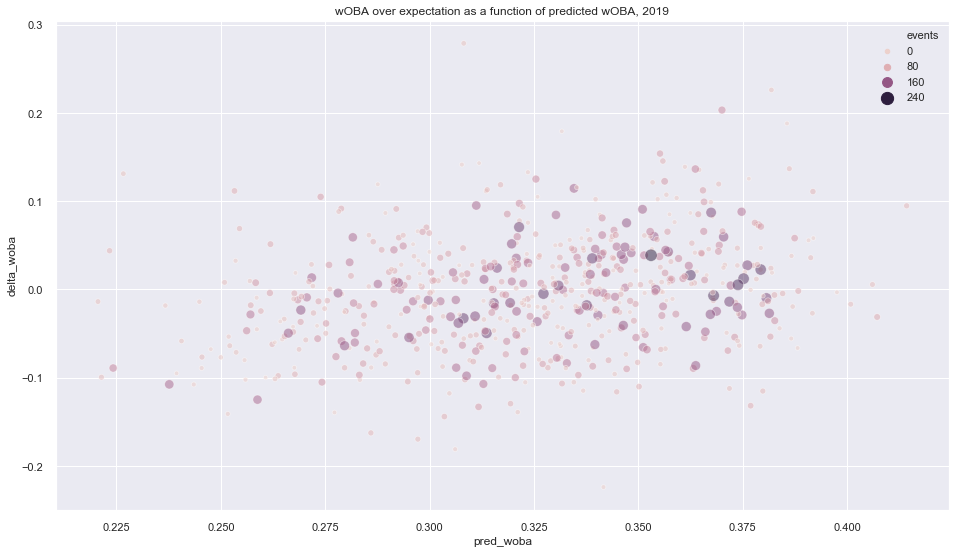

In [57]:
sns.scatterplot(
    x=df_woba_2019_f['pred_woba'],
    y=df_woba_2019_f['delta_woba'],
    hue=df_woba_2019_f['events'],
    size=df_woba_2019_f['events'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('wOBA over expectation as a function of predicted wOBA, 2019')

Text(0.5,1,'wOBA over expectation as a function of pitch count, 2019')

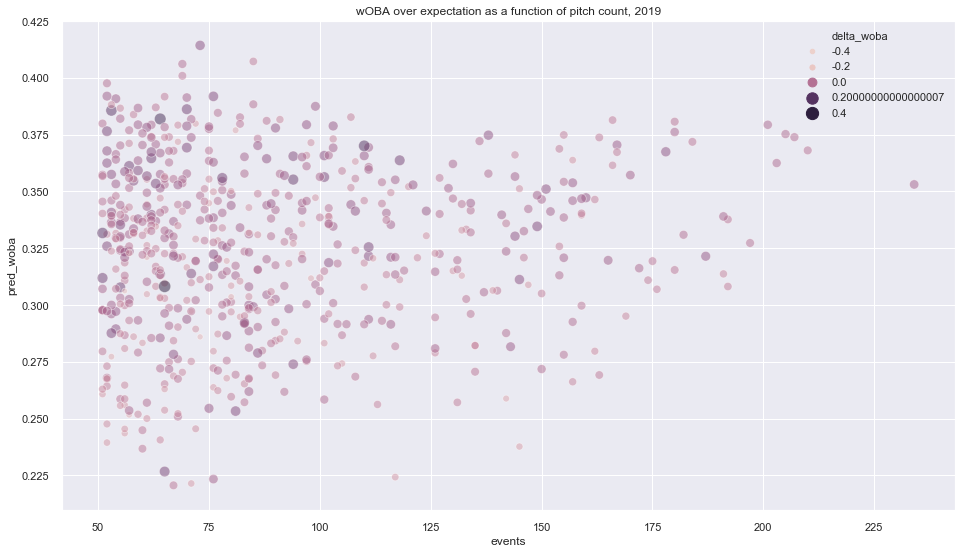

In [58]:
sns.scatterplot(
    x=df_woba_2019_f['events'],
    y=df_woba_2019_f['pred_woba'],
    hue=df_woba_2019_f['delta_woba'],
    size=df_woba_2019_f['delta_woba'],
    sizes=(20, 150),
    alpha=0.5
)

plt.title('wOBA over expectation as a function of pitch count, 2019')

#### Export data

In [59]:
df_woba_2019.to_csv('~/Desktop/expected_woba_2019.csv')
df_summary_woba.to_csv('~/Desktop/expected_woba_all_time.csv')